In [3]:
# %%
# General purpose packages for data processing
import pandas as pd
import numpy as np
import pickle
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

In [4]:
# %%
# Load data
normal = pd.read_csv("power_normal.csv")
anomaly = pd.read_csv("power_attack.csv")

# Add labels
normal['Mode'] = 'Normal'
anomaly['Mode'] = 'Attack'

# Combine datasets
combined = pd.concat([normal, anomaly], axis=0, ignore_index=True)

In [5]:
# %%
# Preprocessing: Group data into chunks of 10 and extract features
def extract_features(data, group_size=10):
    features = []
    labels = []
    for i in range(0, len(data) - group_size + 1, group_size):
        chunk = data.iloc[i:i+group_size]
        # Compute statistical features
        avg = chunk['Power'].mean()
        std = chunk['Power'].std()
        min_val = chunk['Power'].min()
        max_val = chunk['Power'].max()
        range_val = max_val - min_val

        # Append features and label
        features.append([avg, std, min_val, max_val, range_val])
        labels.append(chunk['Mode'].iloc[0])  # Assign label based on first point in the group
    
    # Return as DataFrame
    feature_df = pd.DataFrame(features, columns=['Mean', 'StdDev', 'Min', 'Max', 'Range'])
    feature_df['Mode'] = labels
    return feature_df

# Extract features from combined data
processed_data = extract_features(combined)

# Save processed data
processed_data.to_csv("processed_power.csv", index=False)

In [6]:
# %%
# Features and labels
X = processed_data.drop(columns=['Mode'])  # Features
y = processed_data['Mode']                # Labels

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [7]:
# %%
# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Support Vector Classifier': SVC(kernel='linear', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
}


In [8]:
# Results container
results = {}


--- Evaluating Random Forest ---
Accuracy: 1.0000
F1-Score: 1.0000


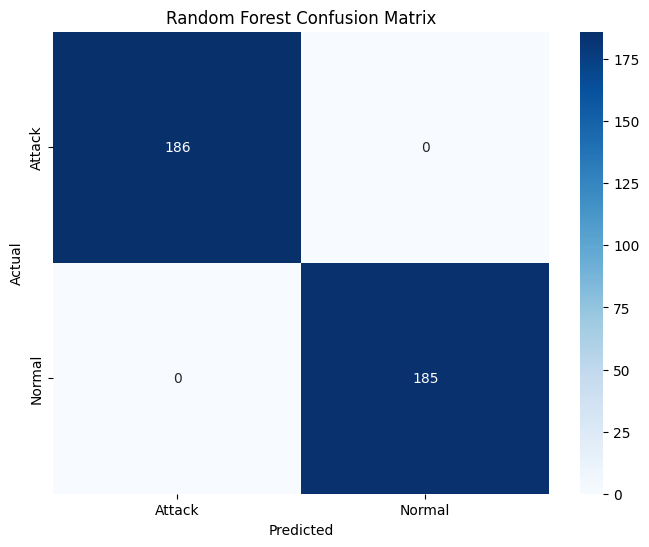


--- Evaluating Support Vector Classifier ---
Accuracy: 0.9946
F1-Score: 0.9946


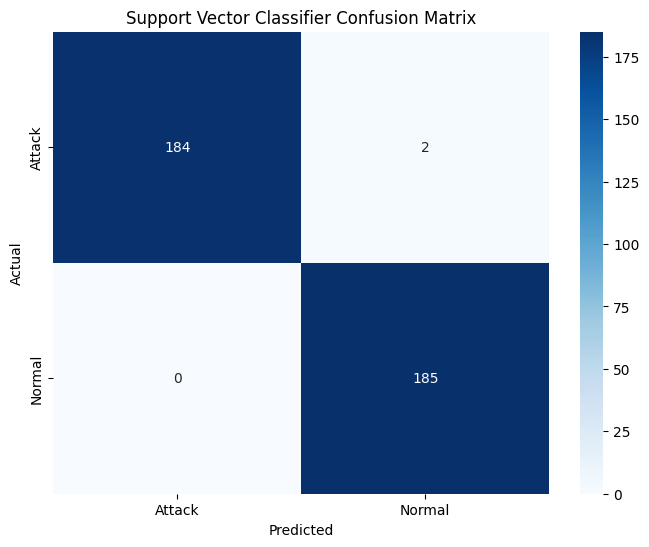


--- Evaluating K-Nearest Neighbors ---
Accuracy: 1.0000
F1-Score: 1.0000


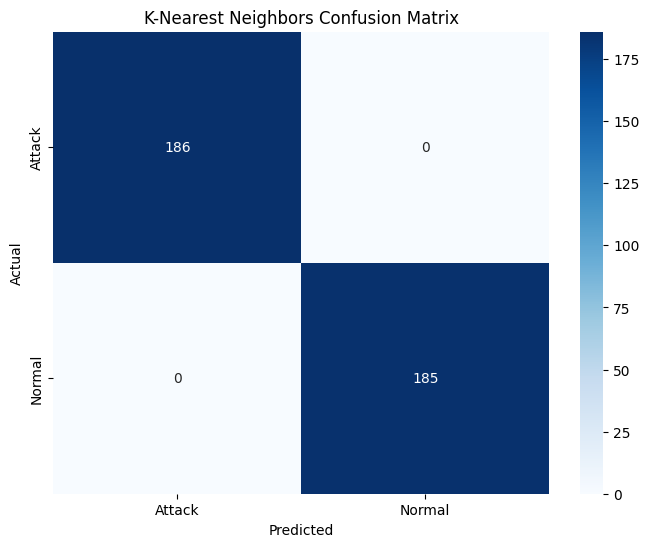

In [9]:
# %%
# Train and evaluate each model
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    conf_matrix = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
    
    # Save results
    results[name] = {
        'Confusion Matrix': conf_matrix,
        'Accuracy': acc,
    }
    
    # Display metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [10]:
# Train final model (Random Forest performed the best in this example)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Save the model to a .pkl file
with open('IDS_power.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

Feature Importances for Power Model:
  Feature  Importance
4   Range    0.330369
1  StdDev    0.290782
3     Max    0.199401
2     Min    0.178805
0    Mean    0.000643


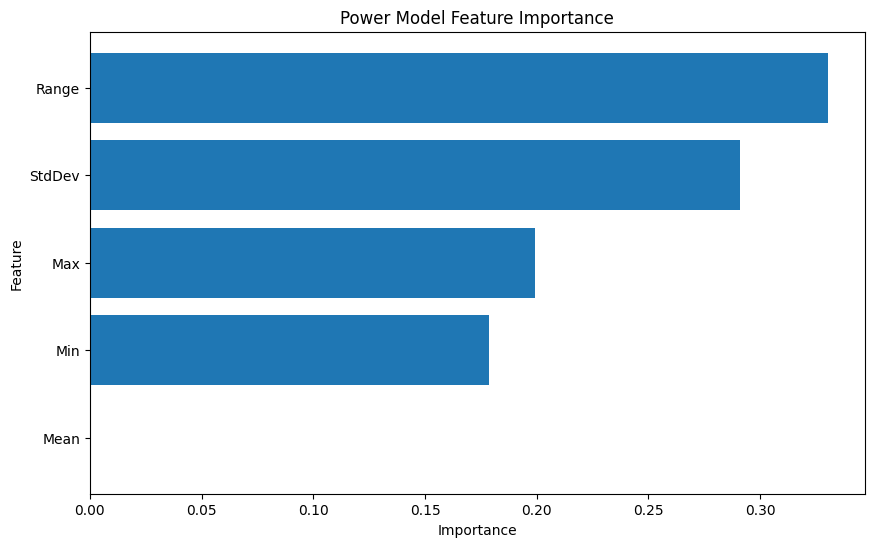

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `rf_model_power` is your trained Random Forest model for the power system
# Assuming `X_train_power` contains the feature data used for training the power model

def plot_power_feature_importance(model, feature_names):
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Print feature importances
    print("Feature Importances for Power Model:")
    print(feature_importance_df)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.title('Power Model Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important at the top
    plt.show()

# Feature names for the power model
power_feature_names = ['Mean', 'StdDev', 'Min', 'Max', 'Range']

# Plot feature importance
plot_power_feature_importance(rf_model, power_feature_names)
